# Initial Data exploration and plots of author collaborations

In [ ]:
import pandas as pd
import numpy as np
import os
import re

## Loading in all data

The excel files with M_sco_du.xlsx suffixes are required. Please change file path accordingly and adjust depending on machine (currently set for Windows).

In [3]:
JOURNALS= ['AER', 'JPE', 'ECTA', 'RES', 'QJE']
#read in all processed masterlists
All=pd.DataFrame()
for i in JOURNALS:
    All=pd.concat([pd.read_excel('C:\\Users\\sjwu1\\Journal_Data\\datadumps\\'+i+'_M_sco_du.xlsx'),All], ignore_index=True)

#Create a batch file

In [26]:
All.columns

Index([     'stable_url',   'Jstor_authors',     'Jstor_title',
        'Jstor_abstract',    'content_type',       'issue_url',
                 'pages',            'year',          'volume',
                 'issue',   'Jstor_journal',            'type',
                       0,  'scopus_authors',    'scopus_title',
        'scopus_journal',             'DOI',    'affiliations',
       'scopus_abstract',       'citations',   'document type',
        'index keywords', 'author keywords',      'Unnamed: 0',
         'document_type',       'footnotes',             'raw',
            'references'],
      dtype='object')

## Consider a reduced set

Let's consider author names in all five economic journals.

In [5]:
Reduced=All[['Jstor_authors', 'year', 'Jstor_journal', 'content_type', 'stable_url']]

In [6]:
R_1940=Reduced[(Reduced['Jstor_authors'].isnull()==False) & (Reduced['year']>=1940)]
R_1940=R_1940.reset_index().drop('index', axis=1)
R_1940.loc[:, 'authors_caps'] = R_1940['Jstor_authors'].copy().str.upper().to_numpy()

R_1940_NM=R_1940[R_1940['content_type']!='MISC'].reset_index().drop('index', axis=1)

In [7]:
df = pd.DataFrame(columns = ['author', 'year', 'journal', 'content_type', 'stable_url'])

for i in R_1940_NM.index:
    if R_1940_NM['content_type'].iloc[i]!='Review':
        authors=R_1940_NM['authors_caps'].iloc[i].replace(' AND ',', ').replace(', JR.',' JR.').replace(', JR',' JR').split(', ')
        for x in authors:
            entry=pd.DataFrame.from_dict({'author': [x], 'year': [R_1940_NM['year'].iloc[i]], 'journal': [R_1940_NM['Jstor_journal'].iloc[i]], 'content_type': [R_1940_NM['content_type'].iloc[i]],'stable_url': [R_1940_NM['stable_url'].iloc[i]]})
            df = pd.concat([entry,df], ignore_index=True)

## Pre-processing for plots

In [9]:
Merged=R_1940_NM
check_data=pd.DataFrame()

In [10]:
for i in Merged.index:
    if ((Merged.iloc[i]['content_type']!='MISC') & (Merged.iloc[i]['content_type']!='Review')):
        authors=[]
        presplit=Merged.iloc[i]['Jstor_authors'].split(' and ')
        for a in presplit:
            if a.__contains__('Jr.') or a.__contains__('Jr'):
                #print('found junior')
                #print(a)
                
                authors=np.concatenate((authors,[a.replace(', Jr.',' Jr.')]))
            else:
                authors=np.concatenate((authors,a.split(', ')))
        #print('_'.join(list(authors))+" "+str(len(authors)) + str(Merged.iloc[i]['year']))
        
        check_data=pd.concat([check_data, pd.DataFrame([{'pdf_url': Merged.iloc[i]['stable_url'],'authors':'\''+'_'.join(list(authors))+'\'', 'num_auth':len(authors),'year':Merged.iloc[i]['year']}])], ignore_index=True)


## Plotting number of collaborators per article over time

This is a simple bar chart.

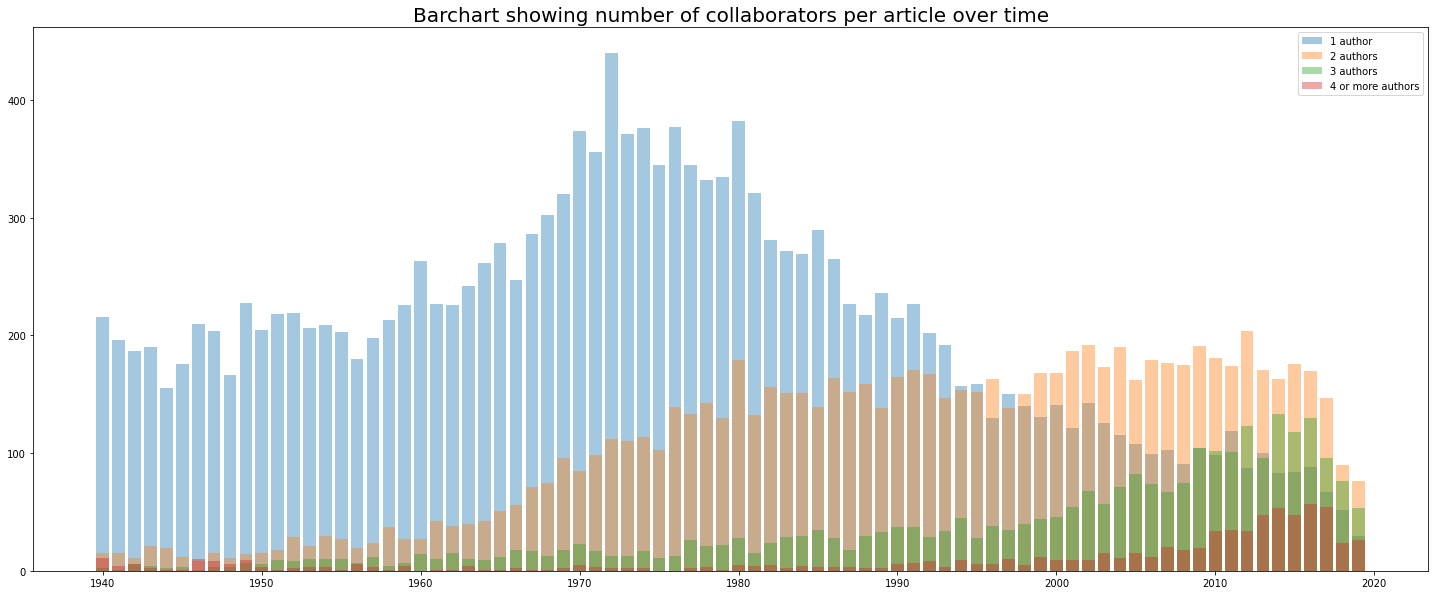

In [12]:
import matplotlib.pyplot as plt    
plt.rcParams["figure.figsize"] = (25, 10)
dta=check_data[check_data['num_auth']==1]['year'].value_counts()
plt.bar(dta.index,dta, label='1 author', alpha=0.4)
dta2=check_data[check_data['num_auth']==2]['year'].value_counts()
plt.bar(dta2.index, dta2, label='2 authors', alpha=0.4)
dta3=check_data[check_data['num_auth']==3]['year'].value_counts()
plt.bar(dta3.index, dta3, label='3 authors', alpha=0.4)
dta4=check_data[check_data['num_auth']>3]['year'].value_counts()
plt.bar(dta4.index, dta4, label='4 or more authors', alpha=0.4)
plt.title('Barchart showing number of collaborators per article over time', size=20)
plt.legend()

## Now to stack them

In [19]:
tmp=pd.DataFrame()
tmp['1 author']=dta
tmp['2 authors']=dta2
tmp['3 authors']=dta3
tmp['4 or more']=dta4

In [20]:
tmp=tmp.reset_index()
tmp=tmp.sort_values(by='index')

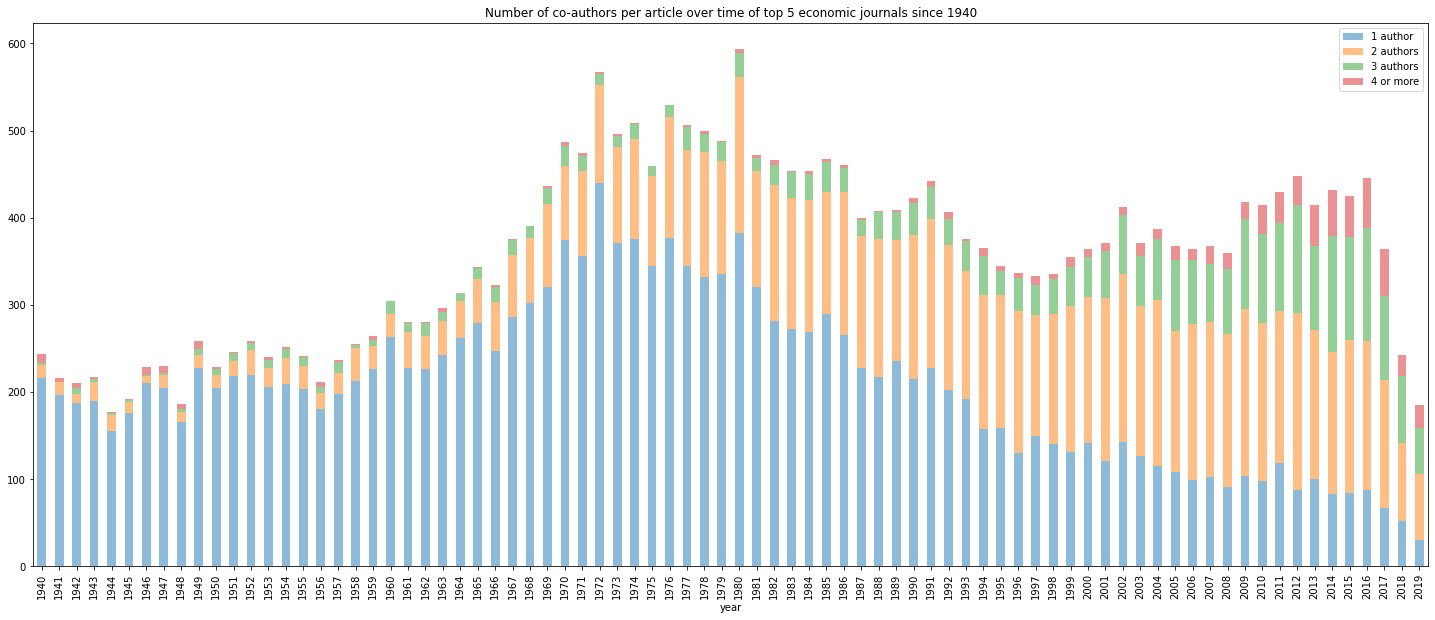

In [23]:
ax=tmp.plot.bar(x='index', 
                stacked=True, 
                title='Number of co-authors per article over time of top 5 economic journals since 1940',
                alpha=0.5, 
                legend=True, 
                xlabel='year')

## 100% bar plot

Unlike the previous plot, the data has not been adjusted for a 'four or more' case which is why the maximum number of collaborators in the plot is 19 authors.

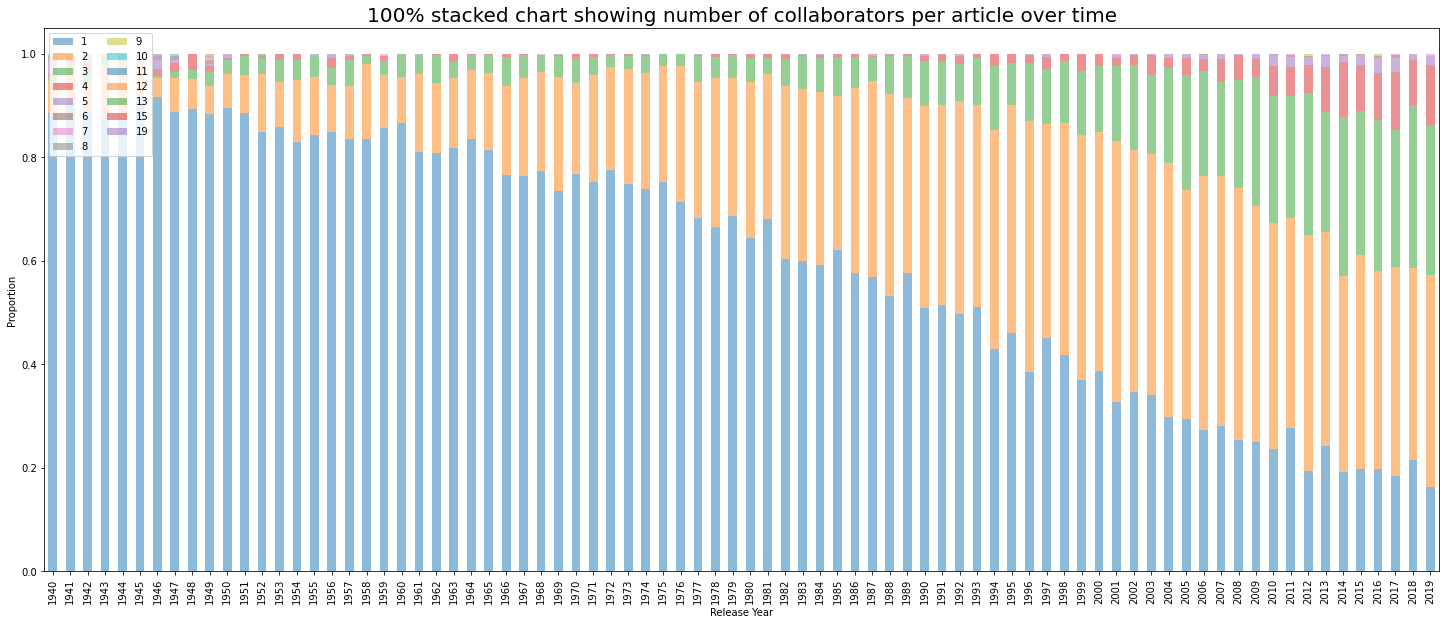

In [24]:
cross_tab_prop = pd.crosstab(index=check_data['year'],
                             columns=check_data['num_auth'],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True, 
                    figsize=(25, 10), 
                    alpha=0.5)
plt.title("100% stacked chart showing number of collaborators per article over time", size=20)
plt.legend(loc="upper left", ncol=2)
plt.xlabel("Release Year")
plt.ylabel("Proportion")
plt.show()